# Clustering of Trajectories under Global Confounding -- Chen-Poor

In [1]:
import sys
# setting path
sys.path.append('../core')
import os
os.environ["VECLIB_MAXIMUM_THREADS"] = "10"


from sklearn.decomposition import PCA

#bread and butter
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

#machine learning library
import sklearn
import sklearn.manifold
import sklearn.cluster
import sklearn.decomposition

#statistics
import scipy
from scipy.stats import rankdata, norm

import numba
from numba import jit, njit

import tqdm
from tqdm import tqdm
import copy
import cvxpy as cp

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
#import numpy as tnp
import warnings
warnings.filterwarnings('ignore')

import dfply
from dfply import *
import ray
import datetime


import os
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import scipy

import confound_mdp
import confound_ope
import confound_env
import copy

from subspace import *
from clustering import *
from emalg import *
from helpers import *

%matplotlib inline
plt.style.use('matplotlibrc')
import os
os.environ["VECLIB_MAXIMUM_THREADS"] = "10"

In [26]:
envs = []
# each row:
#   [mdp , pi_b, pi_e, horizon, gamma, nStates, nActions, term]


horizon = 100 #18
#, slip = 0.04, confound_weight=0.6
pi_b, P, R, x_dist, u_dist, gamma = confound_env.gridworld_opetools(horizon = horizon, slip = 0.04, 
                                                                    confound_weight=0.1, small=False, soft=True)
#R = -1*R
gridworld = confound_mdp.ConfoundMDP(P, R, x_dist, u_dist, gamma)

nStates = P.shape[2]
nActions = P.shape[1]

pi_e = np.zeros((nStates, nActions))
for i in range(nStates):
    pi_e[i] = [0.4, 0.1, 0.4, 0.1]
    
envs.append([gridworld, pi_b, pi_e, horizon, gamma, nStates, nActions, -1, P, R, x_dist, u_dist, gamma])



In [27]:
for mdp , pi_b, pi_e, base_horizon, gamma, nStates, nActions, term, P, R, x_dist, u_dist, gamma in [envs[-1]]:
    
    print("---")
    
    print("running env with horizon", horizon)

    #dataset = confound_mdp.collect_sample(int(100), mdp, pi_b, horizon, iid=False)
    #pi_b = np.array([pi_b.mean(0),pi_b.mean(0)])
    dataset = getSamplesMultiProc(10000, mdp, pi_b, horizon, iid=False)
    data = dataset.reshape((dataset.shape[0]*dataset.shape[1],5))
    Phat = confound_ope.estimate_P(dataset, mdp)
    pihat = confound_ope.estimate_pi(dataset, mdp)
    for a in range(nActions):
        for s in range(nStates):
            if Phat[a,s].sum() == 0:
                Phat[a,s,term] = 1
            if pihat[s].sum() == 0:
                pihat[s,:] = 1/nActions
    pi_avg = pi_b[0] * u_dist[0] + pi_b[1] * u_dist[1]

    # This is the actual reward_sa
    # P(s,a,s') * R(s,a,s')
    # R(s,a) = \Sum_{s'} P(s,a,s') * R(s,a,s')
    R_sa = (np.average(P, axis=0, weights=u_dist) * R).sum(axis=2).T #np.sum(R, axis=2).T #.reshape(nStates, nActions)
    P_spsa = Phat.transpose((2, 1, 0))
    n = data.shape[0]


     # behavior value
    print("value of pi_b")
    returns = confound_mdp.calc_returns(dataset, gamma, horizon)
    print(returns.mean())

---
running env with horizon 100
value of pi_b
-4.228685955734954


In [28]:
from numba import njit
#Ptrue_spsa = np.einsum('u,uasp->psa', u_dist, P)
pi_bsa = np.einsum('u,usa->sa', u_dist, pi_b)
Pb_spsa = getPb_spsa(nStates, nActions, u_dist, pi_b, pi_bsa, P)

burnin = 10
N_sa = getN_sa(dataset, nStates, nActions, burnin=burnin)

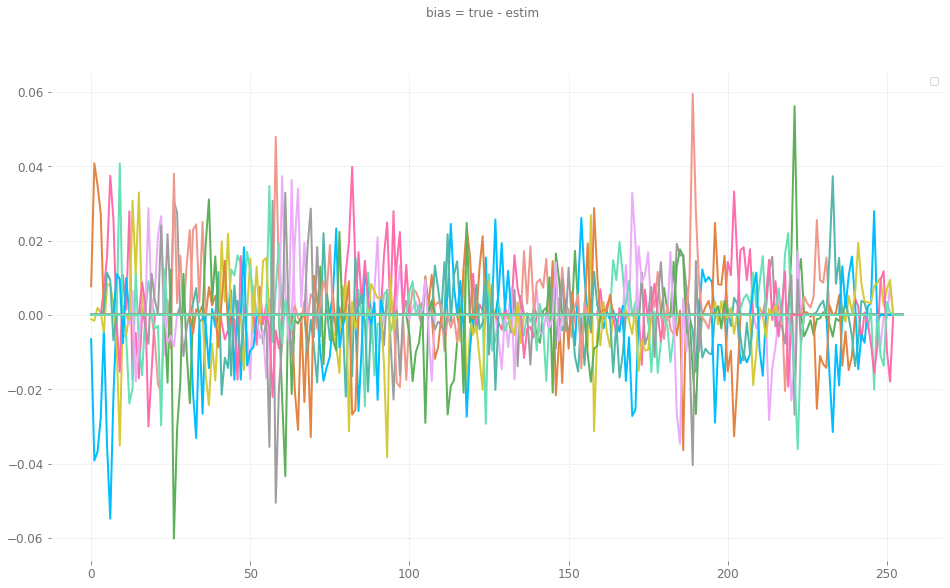

In [7]:
plt.figure(figsize=(16,9))
plt.plot((Pb_spsa - P_spsa).transpose(1,2,0).reshape(nStates*nActions, nStates))
plt.suptitle('bias = true - estim')
plt.legend()

## Method 1: PCA >%> ToMATo Clustering >%> t-SNE

In [8]:
# x, a, u, x', r
dataset.shape

(10000, 100, 5)

In [31]:
stateactions = dataset[:, :, [0, 1]]
X = stateactions.reshape(stateactions.shape[0], stateactions.shape[1]*stateactions.shape[2])
fullX = dataset.reshape(dataset.shape[0], dataset.shape[1]*dataset.shape[2])

memorder = 'C'

#threes = dataset.reshape(int(dataset.shape[0] * dataset.shape[1] / 3), 3, dataset.shape[2])
concattrajs = dataset.reshape(dataset.shape[0]*dataset.shape[1], dataset.shape[2])
threes = np.array([concattrajs[i:i+3] for i in range(len(concattrajs)-2)])
print(threes.shape)
threes = dataset #comment for non-sanity check
print(threes.shape)
if memorder == 'F':
    stateactions = (threes[:,:,0] + threes[:,:,1]*nStates).astype(int) #we code (S x A) as s + a|S|, 0,16,32,48 1,17,33,49
else:
    stateactions = (threes[:,:,0]*nActions + threes[:,:,1]).astype(int)
states = (threes[:,:,0]).astype(int)
actions = (threes[:,:,1]).astype(int)
currstates = threes[:,:,[0,1]].astype(int)
confounders = threes[:,:,2].astype(int)
labels = confounders[:,0].astype(int)
nextstates = threes[:,:,3].astype(int)

L = 2
K = 2
#S = nStates*nActions
#N = len(threes)

(999998, 3, 5)
(10000, 100, 5)


## Mixing Time Analysis

So now we have our dataset encoded in something isomorphic to state-action tuples, we can take a look at mixing times. On a 4x4 gridworld, 15, 31, 47 and 63 correspond to the goal state under Fortran ordering. Under C ordering, it's 60, 61, 62, 63. Here's a plot of the distribution over state-action tuples over time.

In [19]:
np.array([np.bincount(states[:, 0].astype(int)[labels==i])/sum(labels==i) for i in range(max(labels+1))]).shape

(2, 16)

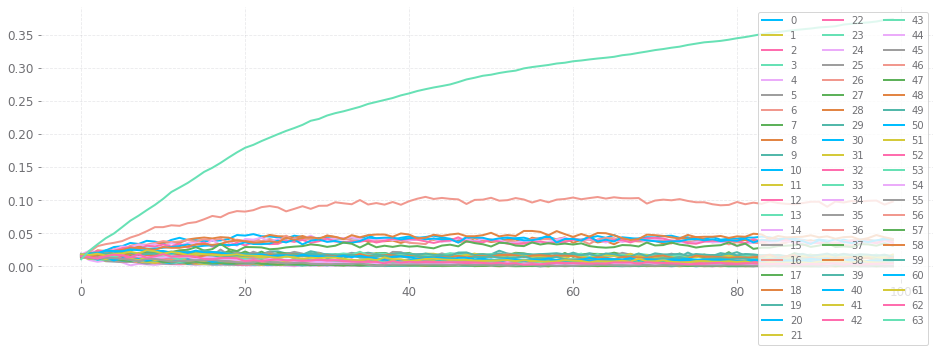

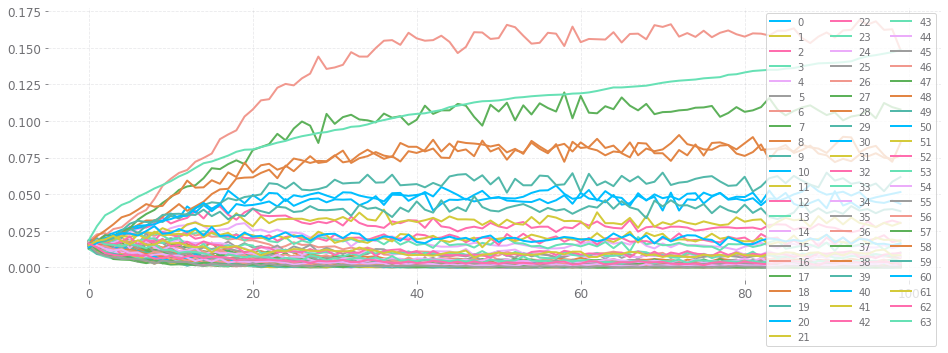

In [6]:
dist = np.array([np.bincount(states[:, i].astype(int)[labels==0], minlength=nStates) 
         for i in range(states.shape[1])])/sum(labels==0)
pd.DataFrame(dist).plot(figsize=(16,5))
plt.legend(ncol=3)
dist = np.array([np.bincount(states[:, i].astype(int)[labels==1], minlength=nStates) 
         for i in range(states.shape[1])])/sum(labels==1)
pd.DataFrame(dist).plot(figsize=(16,5))
plt.legend(ncol=3)

<AxesSubplot:>

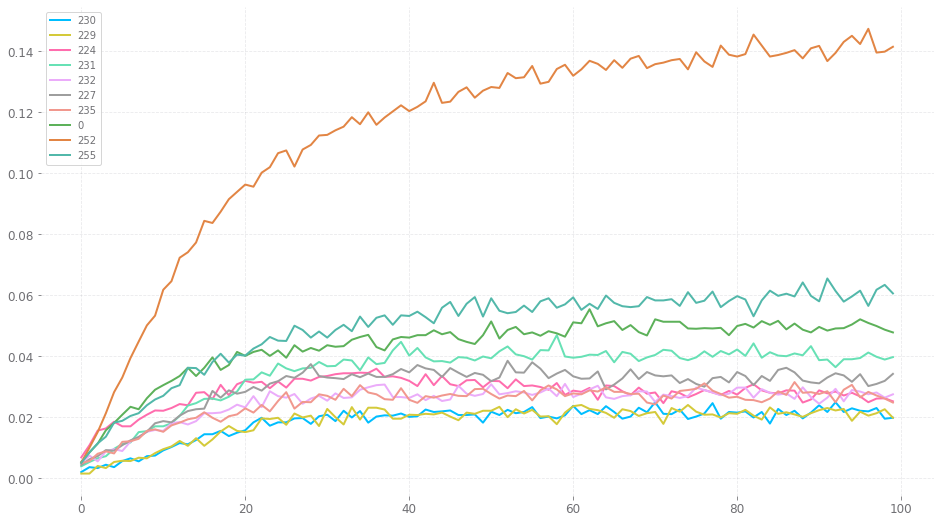

In [11]:
dist = np.array([np.bincount(stateactions[:, i].astype(int), minlength=nStates*nActions) 
         for i in range(stateactions.shape[1])])/len(labels)
pd.DataFrame(dist[:,np.argpartition(dist[-1,:], -10)[-10:]], 
            columns = np.argpartition(dist[-1,:], -10)[-10:]).plot(figsize=(16,9))
#pd.DataFrame(dist[:,[15,31,47,63]]/100000, 
#            columns = [15,31,47,63]).plot(figsize=(16,9))

And here's a plot of the L1-norm between distributions at step t and step t+1 over time. This converges really quickly to something in the neighborhood of 0.02. 

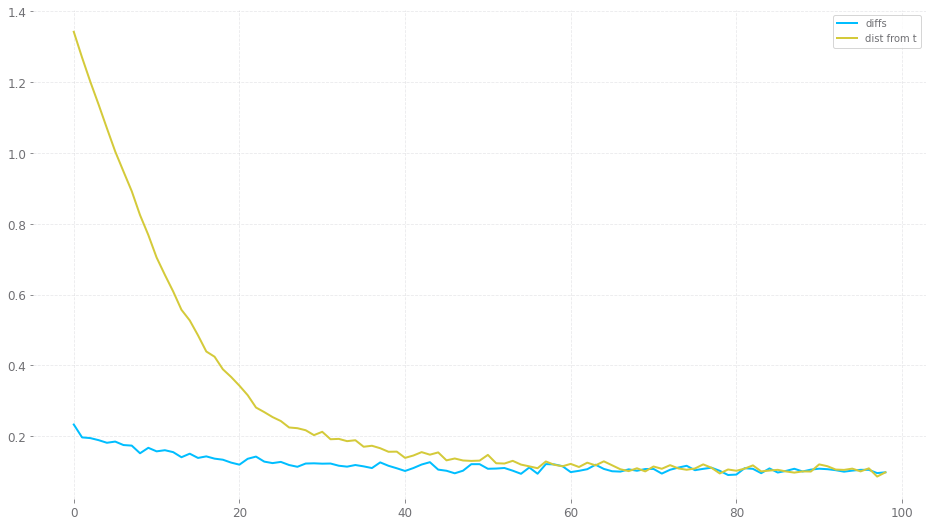

In [12]:
plt.figure(figsize=(16,9))
plt.plot(np.sum(np.abs(np.diff(dist, axis=0)),1), label='diffs')
plt.plot(np.sum(np.abs(dist - dist[-1])[:-1],1), label='dist from t')
plt.legend()

## Subspace Estimation

In [32]:
sadim = nStates*nActions
spdim = nStates
omegaone = np.array([i for i in range(int(horizon/4), 2*int(horizon/4))])
omegatwo = np.array([i for i in range(3*int(horizon/4), horizon)])
onehotsa = np.eye(int(np.max(stateactions))+1)[stateactions]
onehotsaflat = copy.deepcopy(onehotsa)
onehotsa = onehotsa.reshape((onehotsa.shape[0], onehotsa.shape[1], nStates, nActions), order=memorder)
onehotsp = np.eye(np.max(nextstates)+1)[nextstates]
sz = int(onehotsa.shape[0]/3)

In [33]:
onehotsasub = onehotsa[:sz]
onehotsaflatsub = onehotsaflat[:sz]
onehotspsub = onehotsp[:sz]

onehotsaclust = onehotsa[sz:]
onehotsaflatclust = onehotsaflat[sz:]
onehotspclust = onehotsp[sz:]

In [14]:
#np.array([i for i in range(64)]).reshape(nStates, nActions, order=memorder)
#so it turns out the s + a|S| ordering corresponds to Fortran ordering

In [34]:
eigvalsa, eigvecsa = getEig(onehotsasub, onehotspsub, omegaone, omegatwo, K, wt=True)

In [35]:
eigvalsp, eigvecsp = getEigKs(onehotsasub, onehotspsub, omegaone, omegatwo, K)

Finally, as a sanity check, we plot the absolute difference in eigenvalues on the log scale. We want this to always be nonzero, so if any entry is missing in the plot, then we'd be in trouble.

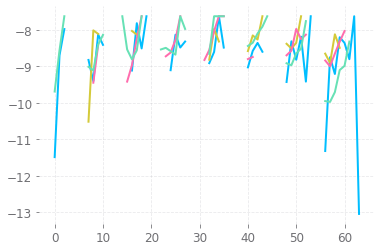

In [97]:
plt.plot(np.log(np.abs(eigvalsa[:,:,0] - eigvalsa[:,:,1])))

In [10]:
vals, vecs = getEig(onehotsasub, onehotspsub, omegaone, omegatwo, 10000, wt=True)

(array([60.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-46.05170186, -45.46799996, -44.88429805, -44.30059615,
        -43.71689425, -43.13319234, -42.54949044, -41.96578854,
        -41.38208663, -40.79838473, -40.21468283, -39.63098092,
        -39.04727902, -38.46357712, -37.87987522, -37.29617331,
        -36.71247141, -36.12876951, -35.5450676 , -34.9613657 ,
        -34.3776638 , -33.79396189, -33.21025999, -32.62655809,
        -32.04285618, -31.45915428, -30.87545238, -30.29175047,
        -29.70804857, -29.12434667, -28.54064476, -27.95694286,
        -27.37324096, -26.78953905, -26.20583715, -25.62213525,
        -25.03843335, -24.45473144, -23.87102954, -23.28732764

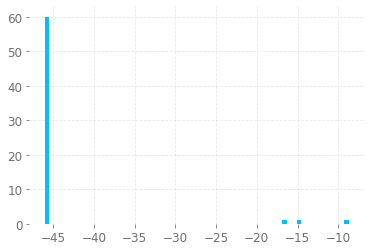

In [11]:
plt.hist(np.log(vals[1,0]+1e-20), bins=64) #(s,a,eigs)

In [18]:
eigvecsa.shape #(s,a,sp,k)

(64, 4, 64, 2)

## Clustering

In [44]:
%load_ext autoreload
%autoreload 2
from clustering import *
import clustering

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
device = "/GPU:0"

hs = np.array([geth(onehotsaclust[:,omegaone,:,:], 
                                     onehotspclust[:,omegaone,:]), 
                              geth(onehotsaclust[:,omegatwo,:,:], 
                                   onehotspclust[:,omegatwo,:])])

statmns = computeStat(hs, 
                      eigvecsa, numpy=False, smalldata=False, device=device, proj=True)
statmns.shape

100%|███████████████████████████████████████████| 64/64 [00:51<00:00,  1.23it/s]


(6667, 6667)

<BarContainer object of 1000 artists>

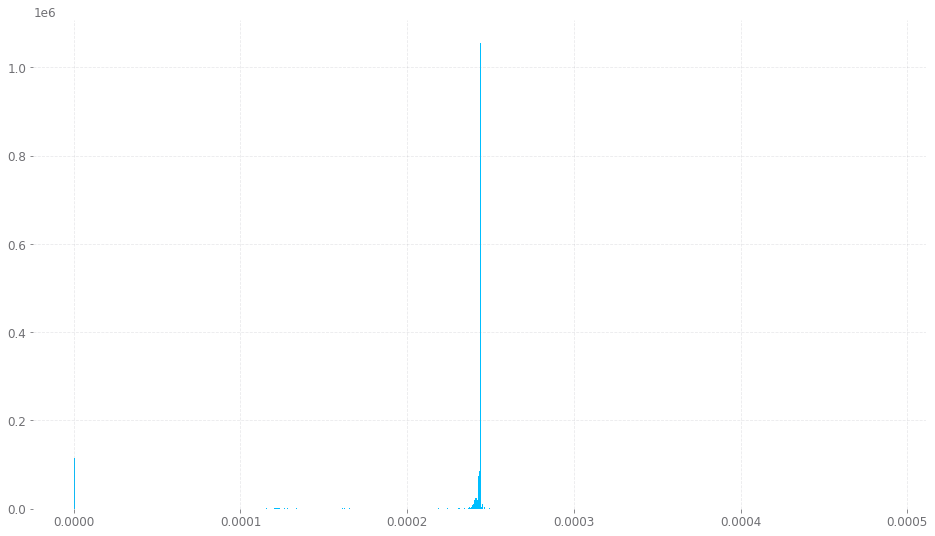

In [12]:
import seaborn as sns
plt.figure(figsize=(16,9))
plt.hist(statmns.flatten(), bins=1000, density=True)[2]
#plt.hist(statmns.flatten(), bins=onehotsaclust.shape[0], density=True)[2]
#sns.kdeplot(statmns.flatten(), bw_adjust=0.5)

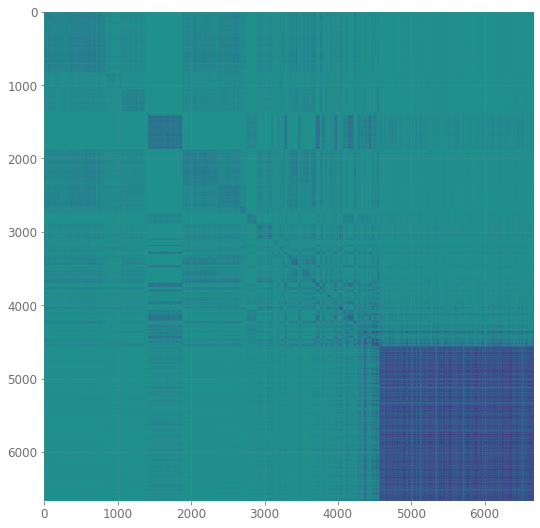

In [13]:
from scipy.cluster.hierarchy import linkage

m = 1-statmns #need similarity matrix
# shuffle
perm = np.random.permutation(len(m))
m = m[perm][:, perm]

# reorder
y = m[np.triu_indices(len(m), k=1)]
Z = linkage(y, method='single', optimal_ordering=True)
perm = np.ravel(Z[:, :2]).astype(np.int32)
perm = perm[perm < len(m)]
m = m[perm][:, perm]

plt.figure(figsize=(16,9))
plt.imshow(1-m)

100%|███████████████████████████████████████████| 20/20 [00:57<00:00,  2.88s/it]


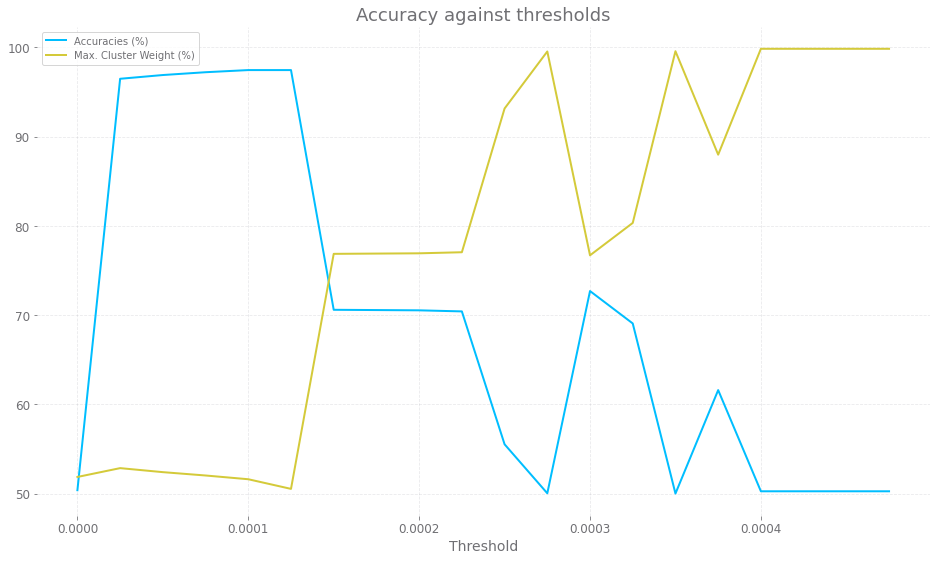

In [37]:
clusterDiagnostics(statmns, K=K, labels=confounders[sz:, 0],
                   lo=0, hi=0.0005, step=0.000025) #0,0.01, 0.0001

In [ ]:
tsne = sklearn.manifold.TSNE(n_components=2, perplexity=5.0, 
                             metric='precomputed').fit_transform(statmns) #1-(statmns2 < 0.002)

NameError: name 'tsne' is not defined

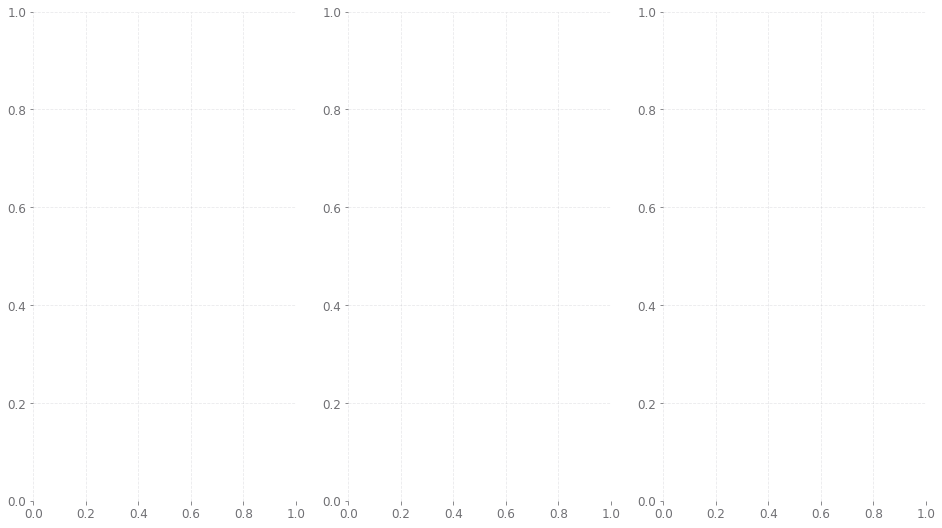

In [38]:
clusterlabs = sklearn.cluster.spectral_clustering((statmns < 0.0001).astype(int), n_clusters=K,
                                                     assign_labels='kmeans')
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=((16,9)))
axes[0].scatter(tsne[:,0], tsne[:,1], c=clusterlabs, cmap='Paired', s=5)
axes[1].scatter(tsne[:,0], tsne[:,1], c=1-clusterlabs, cmap='Paired', s=5)
axes[2].scatter(tsne[:,0], tsne[:,1], c=labels[sz:2*sz], cmap='Paired', s=5)
axes[0].set_title('Clustering Results', fontsize=16)
axes[1].set_title('Permuted Clustering Results', fontsize=16)
axes[2].set_title('True Confounder Labels', fontsize=16)
fig.suptitle('t-SNE Visualizations of Clusters and Confounders, Thresholded Distances', fontsize=24)

In [39]:
permutation = np.argmax([np.mean(clusterlabs == confounders[sz:, 0]), 
                    np.mean(clusterlabs != confounders[sz:, 0])])
print(permutation, np.max([np.mean(clusterlabs == confounders[sz:, 0]), 
                    np.mean(clusterlabs != confounders[sz:, 0])]))

0 0.9746512674366282


(array([5176.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1491.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

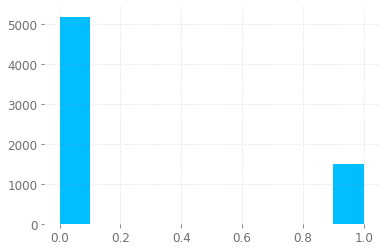

In [37]:
plt.hist(clusterlabs)

## Model Estimation

In [40]:
Phat_ksa = getModelEstim(clusterlabs.astype(int), 
                         states[sz:,:], 
                         actions[sz:,:], 
                         nextstates[sz:,:],
                        K=K, nStates=nStates, nActions=nActions, hard=True)

## Classification

In [21]:
np.bincount(clusterlabs)/len(clusterlabs) 

array([0.48102595, 0.51897405])

In [41]:
#denoised model estimate
Phat_ksad = np.array([eigvecsa @ eigvecsa.transpose(0,1,3,2) @ Phat_ksa[k,:,:,:,None] for k in range(K)]).squeeze()
#projected models
projPhat = np.array([eigvecsa.transpose(0,1,3,2) @ Phat_ksa[k,:,:,:,None] for k in range(K)]).squeeze()


priorclass = np.bincount(clusterlabs)/len(clusterlabs) 
piclust = getPolicyEstim(states[sz:], actions[sz:], 
                         K, nStates, nActions, preds=clusterlabs, hard=True)

startweights = getStartWeights(states[sz:], clusterlabs, K, nStates)
maxapos = classify(Phat_ksa, states[sz:,:], actions[sz:,:], 
                       nextstates[sz:,:], piclust, reg=1, 
                   prior=priorclass, startweights = startweights, labs=True)
mle = classify(Phat_ksa, states[sz:,:], actions[sz:,:], 
                       nextstates[sz:,:], piclust, reg=0, 
               prior=priorclass, startweights = startweights, labs=True)
mleprobs = classify(Phat_ksa, states[sz:,:], actions[sz:,:], 
                       nextstates[sz:,:], piclust, reg=1, 
                    prior=priorclass, startweights = startweights, labs=False)

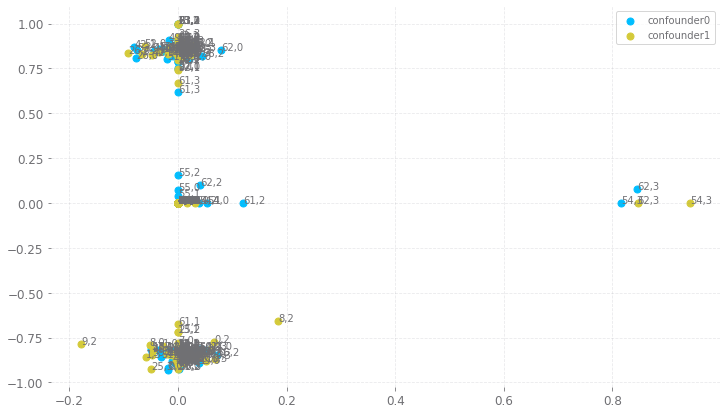

In [65]:
plt.figure(figsize=(12,7))
plt.scatter(projPhat.reshape(K, nStates*nActions, K)[0,:,0], projPhat.reshape(K, nStates*nActions, K)[0,:,1], label='confounder0')
plt.scatter(projPhat.reshape(K, nStates*nActions, K)[1,:,0], projPhat.reshape(K, nStates*nActions, K)[1,:,1], label='confounder1')
for s in range(nStates):
    for a in range(nActions):
        for k in range(K):
            plt.text(projPhat[k,s,a,0], projPhat[k,s,a,1], s=(str(s)+','+str(a)))
plt.legend()

In [42]:
np.mean(labels[2*sz:] == maxapos)
print('MAP estimate accuracy:', [np.mean(labels[sz:] == maxapos), np.mean(labels[sz:] != maxapos)][permutation])
print('MLE accuracy:', [np.mean(labels[sz:] == mle), np.mean(labels[sz:] != mle)][permutation])

MAP estimate accuracy: 0.9851507424628768
MLE accuracy: 0.9851507424628768


In [282]:
%load_ext autoreload
%autoreload 2
from subspace import *
from clustering import *
from emalg import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
expectclass, modelestimclass, loglikclass = em(maxapos, 
                            Phat_ksa, states[sz:], actions[sz:], 
                        nextstates[sz:], labels=labels[sz:], 
                        K=K, nStates=nStates, nActions=nActions,
                        prior = priorclass, reg = 1, max_iter=100,
                                               permute=False, permutation=permutation,
                                               checkin=1, hard=True)

iteration 1 diff 10.773305994248982
6667 6667
accuracy: 0.9851507424628768
-321988.1514735111
iteration 2 diff 0.0
6667 6667
accuracy: 0.9851507424628768
-321988.1514735111
iteration 3 diff 0.0
6667 6667
accuracy: 0.9851507424628768
-321988.1514735111
iteration 4 diff 0.0
6667 6667
accuracy: 0.9851507424628768
-321988.1514735111
iteration 5 diff 0.0
6667 6667
accuracy: 0.9851507424628768
-321988.1514735111
iteration 6 diff 0.0
6667 6667
accuracy: 0.9851507424628768
-321988.1514735111
iteration 7 diff 0.0
6667 6667
accuracy: 0.9851507424628768
-321988.1514735111
iteration 8 diff 0.0
6667 6667
accuracy: 0.9851507424628768
-321988.1514735111
iteration 9 diff 0.0
6667 6667
accuracy: 0.9851507424628768
-321988.1514735111
iteration 10 diff 0.0
6667 6667
accuracy: 0.9851507424628768
-321988.1514735111
log-likelihood: -321988.1514735111


In [44]:
regprobs = 0.9*(np.exp(mleprobs)/np.nansum(np.exp(mleprobs), 0)) + 0.1*np.ones(mleprobs.shape)
expectclasssoft, modelestimclasssoft, loglikclasssoft = em(regprobs, 
                            Phat_ksa, states[sz:], actions[sz:], 
                        nextstates[sz:], labels[sz:], 
                        K=K, nStates=nStates, nActions=nActions,
                        prior = priorclass, reg = 1, permute=False, permutation=permutation, checkin=1, hard=False)

iteration 1 diff 32.191429273912505
6667 6667
accuracy: 0.9850007499625019
-322672.32705124293
iteration 2 diff 24.274575230920235
6667 6667
accuracy: 0.99970001499925
-322060.49385750573
iteration 3 diff 6.227034524948952
6667 6667
accuracy: 1.0
-322031.16088879656
iteration 4 diff 0.4928515659001195
6667 6667
accuracy: 1.0
-322030.67628431565
iteration 5 diff 1.2070500212245926e-13
6667 6667
accuracy: 1.0
-322030.67628431565
iteration 6 diff 1.1655038079446047e-38
6667 6667
accuracy: 1.0
-322030.67628431565
iteration 7 diff 9.792565401509553e-55
6667 6667
accuracy: 1.0
-322030.67628431565
iteration 8 diff 1.8581065687368928e-70
6667 6667
accuracy: 1.0
-322030.67628431565
iteration 9 diff 3.53017280532998e-86
6667 6667
accuracy: 1.0
-322030.67628431565
iteration 10 diff 6.710993290451186e-102
6667 6667
accuracy: 1.0
-322030.67628431565
log-likelihood: -322030.67628431565


## Stable Baselines: EM Algorithm Alone

In [45]:
randlabs = np.random.binomial(1, 0.5, size=len(dataset)).astype(int)
randmodel = getModelEstim(randlabs[sz:], states[sz:], actions[sz:], nextstates[sz:], 
                          K, nStates, nActions, hard=True)
randlabs, randmodel, loglikrand = em(randlabs[sz:], randmodel,
   states[sz:], actions[sz:], nextstates[sz:], labels[sz:], 
                        K=K, nStates=nStates, nActions=nActions,
                        prior = priorclass, reg = 0, permute=True, permutation=True, checkin=1, hard=True)

iteration 1 diff 0.0
6667 6667
accuracy: 0.6514174291285436
-324095.2787487628
iteration 2 diff 24.361132562386118
6667 6667
accuracy: 0.9176541172941353
-324484.99235633784
iteration 3 diff 36.85924588426139
6667 6667
accuracy: 0.983950802459877
-322731.4976271535
iteration 4 diff 22.940863429413433
6667 6667
accuracy: 0.9863506824658768
-322274.4064453342
iteration 5 diff 1.6582854672905258
6667 6667
accuracy: 0.9863506824658768
-322264.0765794221
iteration 6 diff 0.0
6667 6667
accuracy: 0.9863506824658768
-322264.0765794221
iteration 7 diff 0.0
6667 6667
accuracy: 0.9863506824658768
-322264.0765794221
iteration 8 diff 0.0
6667 6667
accuracy: 0.9863506824658768
-322264.0765794221
iteration 9 diff 0.0
6667 6667
accuracy: 0.9863506824658768
-322264.0765794221
iteration 10 diff 0.0
6667 6667
accuracy: 0.9863506824658768
-322264.0765794221
log-likelihood: -322264.0765794221


In [48]:
unifs = np.random.uniform(size=len(dataset))
randlabsoft = np.vstack([unifs, 1-unifs])
randmodelsoft = getModelEstim(randlabsoft, states, actions, nextstates,
                              K, nStates, nActions, hard=False)
randlabsoft, randmodelsoft, loglikrandsoft = em(randlabsoft, randmodelsoft,
   states[sz:], actions[sz:], nextstates[sz:], labels[sz:], 
                        K=K, nStates=nStates, nActions=nActions,
                        prior = priorclass, min_iter = 20, reg = 0, permute=True, permutation=True, checkin=5, hard=False)

iteration 5 diff 14.976676165294489
6667 6667
accuracy: 0.9383530823458827
-322130.50864551053
iteration 10 diff 0.6470609051414169
6667 6667
accuracy: 0.9653517324133793
-322040.7090829349
iteration 15 diff 0.11839017031185219
6667 6667
accuracy: 0.9691015449227539
-322028.1443042671
iteration 20 diff 0.04891615568242041
6667 6667
accuracy: 0.9700014999250037
-322025.5336764597
iteration 25 diff 0.07223738381761464
6667 6667
accuracy: 0.9701514924253787
-322025.34831398353
iteration 30 diff 0.014552506878336986
6667 6667
accuracy: 0.9707514624268787
-322024.4032196716
iteration 35 diff 0.0025351926715488993
6667 6667
accuracy: 0.9709014549272537
-322024.1885251625
log-likelihood: -322024.1221554993


In [ ]:
randlabsoft.argmax(0) != labels

In [49]:
labelsemsoft = []
logliksemsoft = []
for i in tqdm(range(30)):
    unifs = np.random.uniform(size=len(dataset))
    randlabsoft = np.vstack([unifs, 1-unifs])
    randmodelsoft = getModelEstim(randlabsoft, states, actions, nextstates,
                              K, nStates, nActions, hard=False)
    randlabsoft, randmodelsoft, loglikrand = em(randlabsoft, randmodelsoft,
   states, actions, nextstates, labels, 
                        K=K, nStates=nStates, nActions=nActions,
                        prior = priorclass, reg = 0, permute=True, permutation=permutation, checkin=1, verbose=False, hard=False)
    labelsemsoft.append(randlabsoft)
    logliksemsoft.append(loglikrand)

100%|███████████████████████████████████████████| 30/30 [00:52<00:00,  1.74s/it]


In [50]:
labelsem = []
logliksem = []
for i in tqdm(range(30)):
    randlabs = np.random.binomial(1, 0.5, size=len(dataset)).astype(int)
    randmodel = getModelEstim(randlabs, states, actions, nextstates,
                              K, nStates, nActions, hard=True)
    randlabs, randmodel, loglikrand = em(randlabs, randmodel,
       states, actions, nextstates, labels, 
                        K=K, nStates=nStates, nActions=nActions,
                        prior = priorclass, reg = 0, permute=True, permutation=permutation, checkin=1, verbose=False, hard=True)
    labelsem.append(randlabs)
    logliksem.append(loglikrand)

100%|███████████████████████████████████████████| 30/30 [00:39<00:00,  1.30s/it]


0.9060533333333333
0.95855
0.9923


Text(0.5, 1.0, 'Randomly Initialized Hard EM Algorithm')

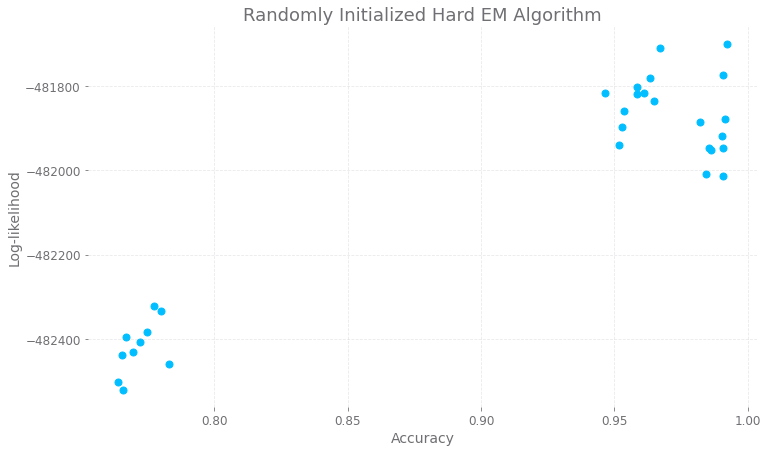

In [53]:
plt.figure(figsize=(12,7))
plt.scatter([max(np.mean(i == labels), np.mean(i != labels)) for i in labelsem], logliksem)
print(np.mean([max(np.mean(i == labels), np.mean(i != labels)) for i in labelsem]))
print(np.median([max(np.mean(i == labels), np.mean(i != labels)) for i in labelsem]))
print(np.max([max(np.mean(i == labels), np.mean(i != labels)) for i in labelsem]))
plt.xlabel('Accuracy')
plt.ylabel('Log-likelihood')
plt.title('Randomly Initialized Hard EM Algorithm')

In [112]:
np.mean(np.array([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)])==1)

0.4666666666666667

0.9366533333333333
0.9712
1.0


Text(0.5, 1.0, 'Randomly Initialized Soft EM Algorithm')

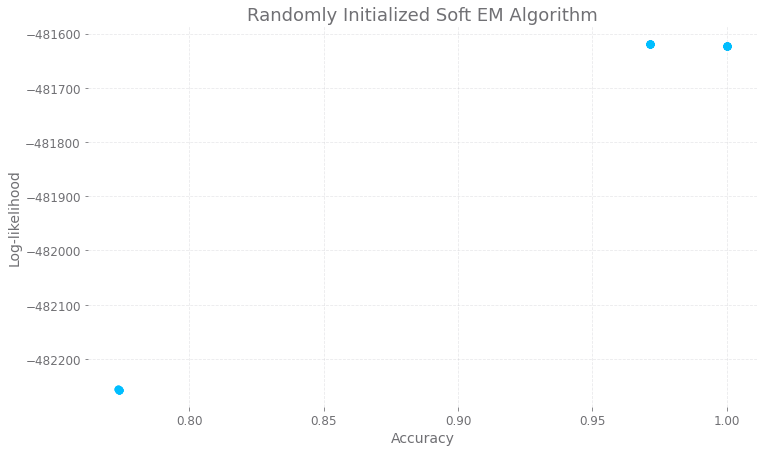

In [54]:
plt.figure(figsize=(12,7))
plt.scatter([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)], 
            logliksemsoft)
print(np.mean([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)]))
print(np.median([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)]))
print(np.max([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)]))
plt.ticklabel_format(style='plain',useOffset=False)
plt.xlabel('Accuracy')
plt.ylabel('Log-likelihood')
plt.title('Randomly Initialized Soft EM Algorithm')

(array([ 0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5]),
 <BarContainer object of 10 artists>)

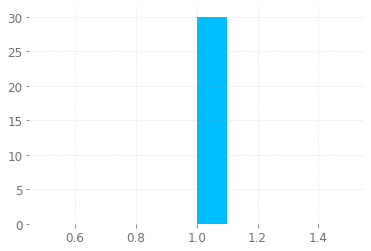

In [141]:
plt.hist([max(np.mean(i == labels[sz:]), np.mean(i != labels[sz:])) for i in np.array(labelsemsoft).argmax(axis=1)])

(array([17.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 13.]),
 array([0.69266537, 0.71847908, 0.74429279, 0.77010649, 0.7959202 ,
        0.82173391, 0.84754762, 0.87336133, 0.89917504, 0.92498875,
        0.95080246]),
 <BarContainer object of 10 artists>)

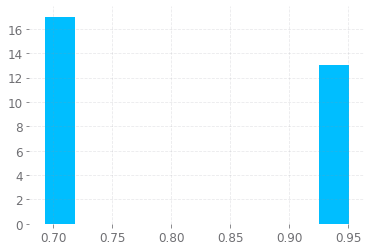

In [95]:
plt.hist([max(np.mean(i == labels[sz:]), np.mean(i != labels[sz:])) for i in labelsem])

## Stable Baselines: Occupancy Counts Past Mixing Time

In [160]:
onehots = onehotsaclust[:, omegatwo,...].sum(1)
statbase = np.abs(onehots[None,...] - onehots[:,None,...]).sum(axis=(2,3))
tsnebase = sklearn.manifold.TSNE(n_components=2, perplexity=5.0, 
                                 metric='precomputed').fit_transform(statbase)
clusterlabs = sklearn.cluster.spectral_clustering((statbase.max() - statbase), n_clusters=K,
                                                     assign_labels='kmeans')
max(np.mean(clusterlabs == labels[sz:2*sz]), np.mean(clusterlabs != labels[sz:2*sz]))

0.9882988298829883

In [162]:
transitions = geth(onehotsa, onehotsp, simple=False)

In [ ]:
statnaive = np.abs(transitions[None,...] - transitions[:,None,...]).sum(axis=(2,3,4))

Text(0.5, 0.98, 't-SNE Visualizations of Clusters and Confounders, Thresholded Distances')

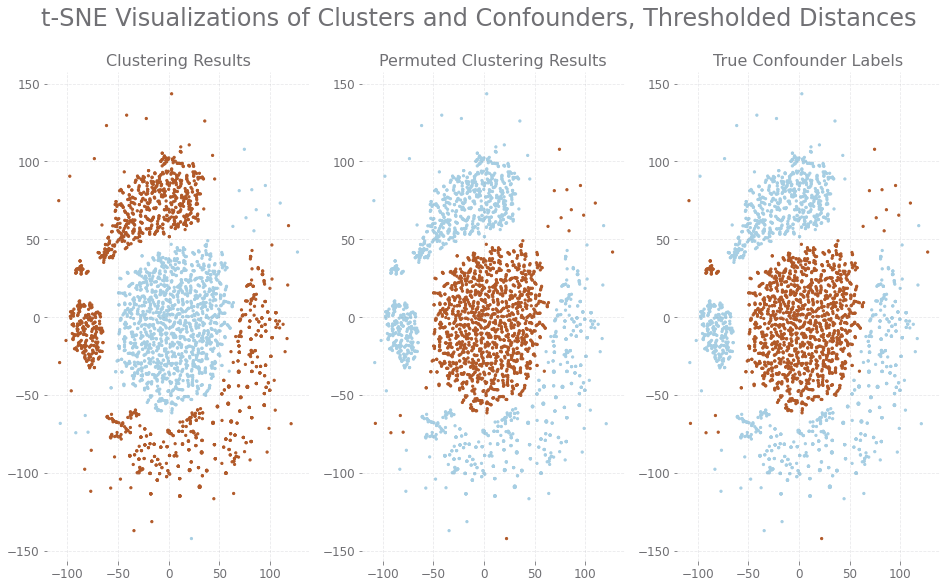

In [86]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=((16,9)))
axes[0].scatter(tsnebase[:,0], tsnebase[:,1], c=clusterlabs, cmap='Paired', s=5)
axes[1].scatter(tsnebase[:,0], tsnebase[:,1], c=1-clusterlabs, cmap='Paired', s=5)
axes[2].scatter(tsnebase[:,0], tsnebase[:,1], c=labels[sz:2*sz], cmap='Paired', s=5)
axes[0].set_title('Clustering Results', fontsize=16)
axes[1].set_title('Permuted Clustering Results', fontsize=16)
axes[2].set_title('True Confounder Labels', fontsize=16)
fig.suptitle('t-SNE Visualizations of Clusters and Confounders, Thresholded Distances', fontsize=24)

## MLE vs MAP

Text(0.5, 0.98, 't-SNE Visualizations of Post-Refinement MLE and Confounders, Thresholded Distances')

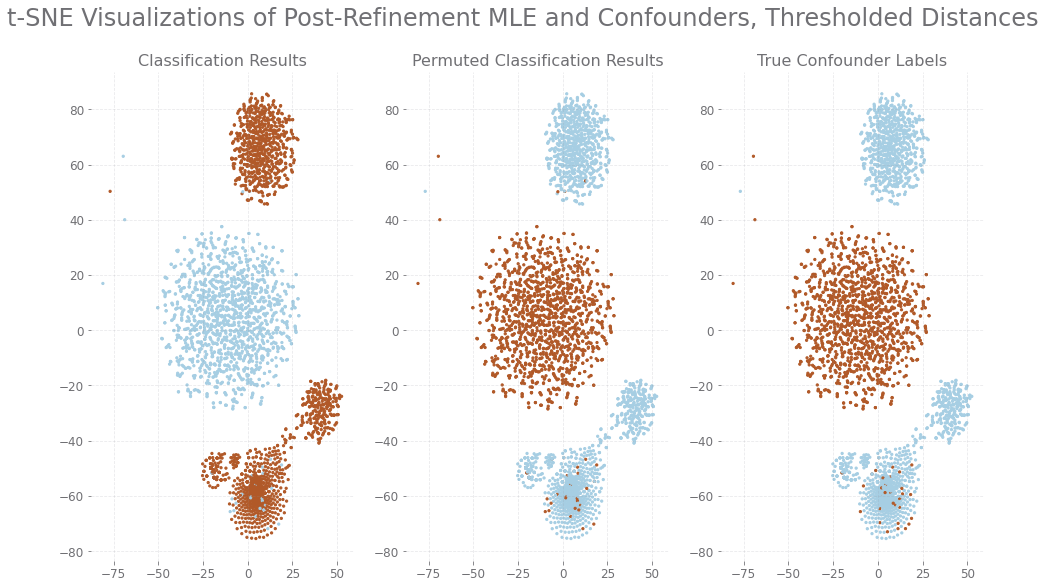

In [87]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=((16,9)))
axes[0].scatter(tsne[:,0], tsne[:,1], c=refinemlelab[:sz], cmap='Paired', s=5)
axes[1].scatter(tsne[:,0], tsne[:,1], c=1-refinemlelab[:sz], cmap='Paired', s=5)
axes[2].scatter(tsne[:,0], tsne[:,1], c=labels[sz:2*sz], cmap='Paired', s=5)
axes[0].set_title('Classification Results', fontsize=16)
axes[1].set_title('Permuted Classification Results', fontsize=16)
axes[2].set_title('True Confounder Labels', fontsize=16)
fig.suptitle('t-SNE Visualizations of Post-Refinement MLE and Confounders, Thresholded Distances', fontsize=24)

Text(0.5, 0.98, 't-SNE Visualizations of Post-Refinement MAP Labels and Confounders, Thresholded Distances')

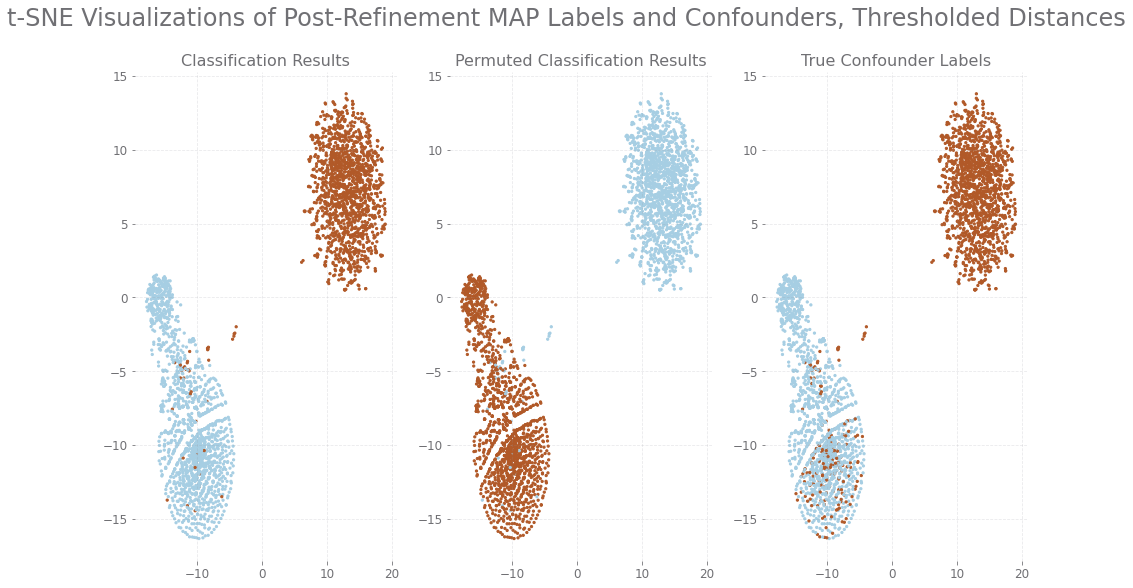

In [100]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=((16,9)))
axes[0].scatter(tsne[:,0], tsne[:,1], c=refinemaplab[:sz], cmap='Paired', s=5)
axes[1].scatter(tsne[:,0], tsne[:,1], c=1-refinemaplab[:sz], cmap='Paired', s=5)
axes[2].scatter(tsne[:,0], tsne[:,1], c=labels[sz:2*sz], cmap='Paired', s=5)
axes[0].set_title('Classification Results', fontsize=16)
axes[1].set_title('Permuted Classification Results', fontsize=16)
axes[2].set_title('True Confounder Labels', fontsize=16)
fig.suptitle('t-SNE Visualizations of Post-Refinement MAP Labels and Confounders, Thresholded Distances', fontsize=24)